<a href="https://colab.research.google.com/github/Robin-01/UW-DSO/blob/main/Tutorials2025/ML/ML_Tutorial_Part2_Phytoplankton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning (ML)

## Part II: Deep Learning using Convolutional Neural Networks

<img src="https://github.com/gmanuch/DataScienceOceanography/blob/main/Tutorials2025/ML/plankton%20diagram.png?raw=1" width=1000/>

This tutorial is part of our Machine Learning day. It demonstrates how to build a deep learning model and prepare an input data pipeline for a real-world ocean science problem -- automatically labelling images of plankton with the correct species label!  

### Estimated tutorial time: 1.5 hours

## Tutorial goals
- Python Skills
    - Work with TensorFlow and Keras packages for machine learning
    - Load and process large number of images from original source
    - Visualise data to make sure it is appropriate for feeding to the deep learning model
    - Calculate confusion matrix
- ML knowledge
    - Learn about supervised learning for image classification
    - Learn how to deal with class imbalance in the training data
    - Learn how to build a simple Convolutional Neural Network (CNN) model
    - Learn how to prepare image data for input into a CNN
    
## Data

- Imaging FlowCytobot (IFCB) is an autonomous submersible flow cytometer developed at the Woods Hole Oceanographic Institute (WHOI). IFCB automatically photographs (through a microscope) plankton from seawater sizes down to around 10 microns. The instrument has been deployed at the Martha's Vineyard Coastal Observatory at a depth of 4m since 2006, providing a continuous time series of plankton images over multiple years. These data are important for studying the structure of ocean ecosystems. There are far too many images for human experts to hand label the species of every plankton, so an automated labelling procedure is necessary. To help train machine learning models for this task, scientists at WHOI produced a dataset of over 3.5 million images that were hand-labelled by experts: https://github.com/hsosik/WHOI-Plankton.

- We pre-downloaded the image files from the website using the script __download_plankton.py__ to save time. The first part of this notebook will show how to prepare a dataset from this large quantity of image files, but we also saved a file __processed_dataset.??__ to save time, so you can go ahead and just load this file if you want to try out different deep learning models on the pre-processed data.




    
## Reading

Gonzalez, P., et al., 2019, Automatic plankton quantification using deep features, Journal of Plankton Research (https://doi.org/10.1093/plankt/fbz023).

# Let's start!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" # uncomment to disable GPU
import tensorflow as tf
from tensorflow import keras

## Data, data, data -- so much data!

The data consists of thousands of images (.png files) of plankton taken using IFCB. Each plankton image has been classified by an expert. The data is organised into directories with subdirectories for each class. First, let's read through the directories to list all the classes in the dataset.

# Start the notebook from here to skip pre-processing of the images.
### Load the google drive folder or copy the .npy files from WHOI-Plankton folder -- those contain images and their labels

In [4]:
dir='/content/drive/MyDrive/UW-DSO 2025/WHOI-Plankton/' #specify your dir here

IMAGES = np.load(dir+'IMAGES.npy')
IM_class = np.load(dir+'IM_class.npy')
class_labels = np.load(dir+'class_labels.npy')

keep_classes=np.array(['Leptocylindrus', 'dino30' , 'Guinardia_delicatula', 'Rhizosolenia',
 'Chaetoceros', 'Cerataulina', 'Ciliate_mix', 'Cylindrotheca', 'Skeletonema', 'Thalassiosira'])
N_classes=len(np.unique(class_labels))

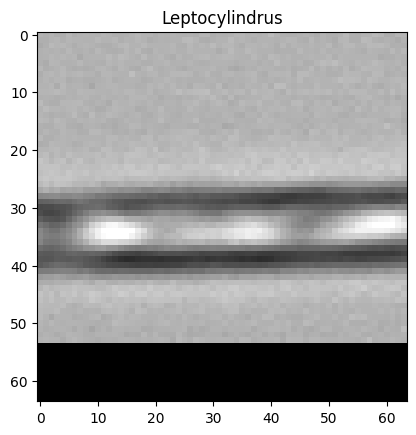

In [5]:
#plot a random image
N=5000
plt.imshow(IMAGES[N], cmap='grey')
plt.title(keep_classes[class_labels[N]]);

# Deep Learning

Now that we have the desired data loaded in an appropriate format, it's time to design a deep neural network. We will explore Convolutional Neural Networks (CNNS), which are some of the most powerful neural network architectures for analysis of images. You can read up on the basic ideas behind a CNN here: https://levelup.gitconnected.com/a-gentle-introduction-to-convolutional-neural-networks-98923560578f. This type of neural network was pioneered by Yann LeCun and others in the 1990's to recognise hand-written ZIP codes on mail envelopes (their original paper: http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf , it's very long so you don't have to read all of it!). In the decades since, CNNs have exploded in popularity and have been developed for all sorts of state-of-the-art computer vision applications.

We won't have time to cover them today, but here are just a few of the other popular neural network architectures used by researchers today: Multilayer Perceptrons (MLPs), Transformer Networks, Generative Adversarial Networks (GANs), Long Short-Term Memory (LSTM), Graph Neural Networks, plus countless more!

Here, we'll have a go at developing a simple CNN to predict the species of our plankton images. We'll use the TensorFlow (https://www.tensorflow.org/api_docs) and Keras (https://keras.io/api/) APIs for building and training our neural network.

A CNN takes as input a tensor of shape (N_rows, N_cols, N_channels) representing an image. Since we're using black and white images, N_channels = 1 for our problem (N_channels = 3 for a colour image, corresponding to RGB).

So our input should have shape: (64,64,1), let's reshape our image data and call it X.

For the class labels, we'll use 'one-hot' encoding (https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics). So we replace the strings representing our class labels with vectors of length 10 (for the 10 classes) with a 1 in the vector entry corresponding to the right class label and 0 everywhere else. Our CNN will output a similar vector of length 10, with each entry corresponding to the probability the network predicts for the image to belong to each class.

Luckily for us, the Keras API can create this one-hot encoding for us!

In [6]:
# reshape the images for input to CNN
X= np.expand_dims(IMAGES, axis=3)
# create the one-hot encoding of the training labels
Y = keras.utils.to_categorical(class_labels, len(keep_classes))

In [7]:
keep_classes

array(['Leptocylindrus', 'dino30', 'Guinardia_delicatula', 'Rhizosolenia',
       'Chaetoceros', 'Cerataulina', 'Ciliate_mix', 'Cylindrotheca',
       'Skeletonema', 'Thalassiosira'], dtype='<U20')

In [17]:
Y[100]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [25]:
class_labels

array([0, 0, 0, ..., 9, 9, 9])

In [26]:
X[1]

array([[[0.627451  ],
        [0.62352943],
        [0.62352943],
        ...,
        [0.63921571],
        [0.627451  ],
        [0.62352943]],

       [[0.6156863 ],
        [0.61960787],
        [0.627451  ],
        ...,
        [0.627451  ],
        [0.62352943],
        [0.62352943]],

       [[0.61176473],
        [0.61960787],
        [0.62352943],
        ...,
        [0.627451  ],
        [0.62352943],
        [0.63137257]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

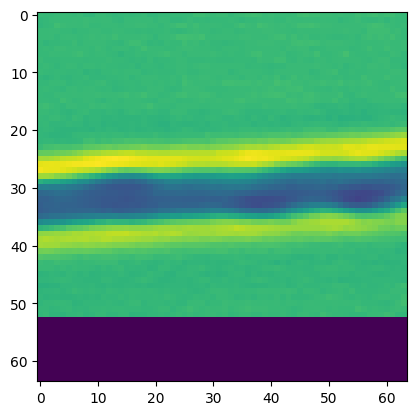

In [33]:
plt.imshow(X[1])
Y[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Now we'll define a simple CNN model with 5 convolutional layers, each followed by a max pooling layer. This sequence of layers allows the network to recognise features from the images independent of where within the image they are (if a plankton is moved 2 microns to the left it's still the same plankton!). These features are aggregated together for the whole image by the GlobalAveragePooling layer before being passed to a fully connected ('Dense') layer to predict the class probabilities from the image features. The weights in the fully connected layer are randomly dropped (Dropout) during training to reduce the risk of overfitting.

During training, the network seeks to minimise its loss function. Here, we use 'categorical cross entropy' which takes a smaller value when the predicted probability approaches 100% for the correct class: $$loss = - \sum_{i=1}^{N}y_i\text{log}(p_i),$$
where $N$ is the number of classes (10 in our case), $y_i$ is the true one-hot encoding value for the i-th class (0 or 1), and $p_i$ is the network's predicted probability for that class.

In [8]:
# define a simple CNN model to classify plankton types
def create_cnn_model(input_shape, output_shape):

    x = keras.layers.Input(shape=input_shape)

    y = keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(x) # add a convolutional layer with a ReLU activation
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)     # add a max pooling layer

    y = keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(y)

    y = keras.layers.GlobalAveragePooling2D()(y)

    y = keras.layers.Dropout(0.5)(y)

#    y = keras.layers.Dense(128, activation='relu')(y)

    y = keras.layers.Dense(output_shape, activation='softmax')(y)     # add final output layer with a softmax activation

    model = keras.models.Model(inputs=x, outputs=y)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [9]:
CNN = create_cnn_model(input_shape=(64,64,1), output_shape=len(keep_classes))
# take a look at how the image tensor changes shape as it passes through the CNN:
CNN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,530 (388.79 KB)

 Trainable params: 99,530 (388.79 KB)

 Non-trainable params: 0 (0.00 B)

Our CNN is now ready to train! To prevent overfitting (https://en.wikipedia.org/wiki/Overfitting), we need to split our dataset into a training set and a validation set. The validation set will only be used to monitor the progress during training (the network parameters aren't adjusted in response to the performance on the validation data) and to test the network's accuracy at the end.

After splitting the data, we'll then train our model. The number of epochs refers to the number of times the model sees the full training dataset during training. The batch_size refers to the number of examples passed to the model between updates of the network parameters.

In [10]:
%%time
# fraction of the dataset to use for validation
val_split=0.2

# randomly select the val indices to ensure random mix of classes
ind_val= (np.random.rand(X.shape[0])<val_split)

X_val=X[ind_val]
Y_val=Y[ind_val]

class_labels_val=class_labels[ind_val]

# remaining data goes in the training dataset
X_train=X[~ind_val]
Y_train=Y[~ind_val]

# train the model, and save the progress to hist (hist will be a dictionary)
n_epochs = 20
hist = CNN.fit(x = X_train, y = Y_train, epochs=n_epochs, batch_size=512, validation_data=(X_val,Y_val))

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.1744 - loss: 2.1353 - val_accuracy: 0.3800 - val_loss: 1.6351
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.3810 - loss: 1.5707 - val_accuracy: 0.5286 - val_loss: 1.2566
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4917 - loss: 1.3130 - val_accuracy: 0.5371 - val_loss: 1.2145
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5361 - loss: 1.2280 - val_accuracy: 0.6088 - val_loss: 1.0650
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5823 - loss: 1.1283 - val_accuracy: 0.6427 - val_loss: 1.0135
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6020 - loss: 1.0714 - val_accuracy: 0.6618 - val_loss: 0.9499
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6377 - loss: 1.0018 - val_accuracy: 0.6815 - val_loss: 0.9081
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6486 - loss: 0.9656 - val_acc

Let's see how we did!

We'll use accuracy as our performance metric. This is the average per-class effectiveness of the class predictor, i.e. $\frac{TP+TN}{TP+TN+FP+FN}$, where TP = true positive, TN = true negative, FP = false positive, and FN = false negative. So the accuracy would tend to 1 for a perfect predictor.

If we randomly guess classes, we should expect the accuracy to be $1/N = 0.1$. So we can use this as a baseline, if we do worse than this then we really messed up!

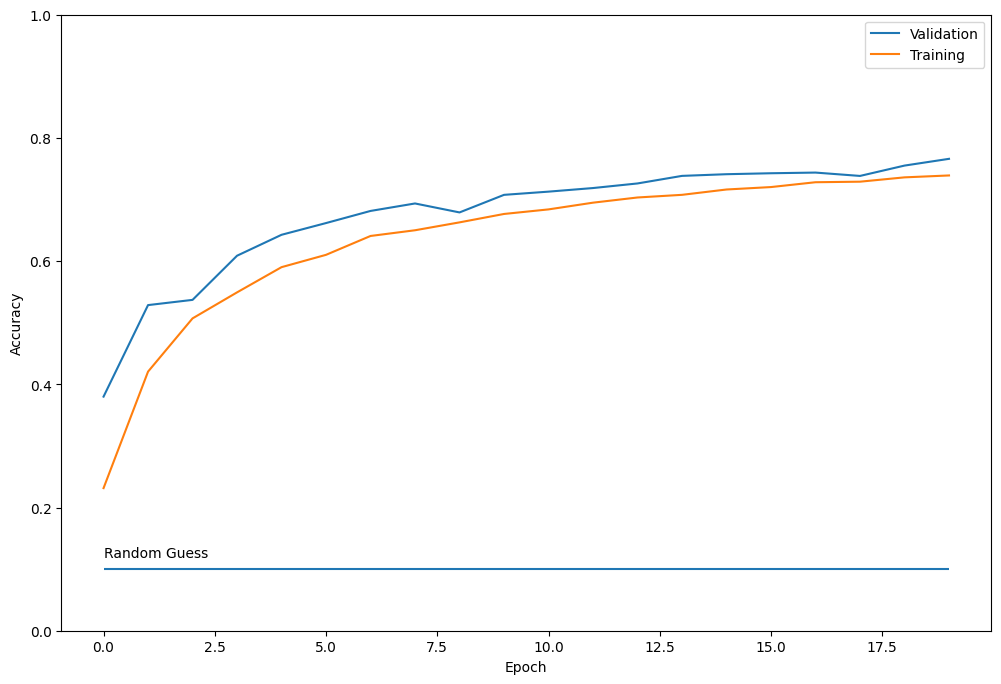

In [11]:
# plot how the accuracy on the training and validation datasets evolved during training
plt.figure(figsize=(12,8))
plt.plot(hist.history['val_accuracy'],label='Validation')
plt.plot(hist.history['accuracy'],label='Training')
plt.ylim([0,1])
plt.hlines(0.1,0,n_epochs-1)
plt.annotate('Random Guess',(0, 0.12))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

**Bonus question to think about at home:** We expect the training accuracy to be higher than the validation accuracy, but for the first few epochs the validation accuracy appears to be higher. Can you explain why?

*hint:* It's to do with when in an epoch these accuracies are calculated...

To get a better feel for how the network is doing, let's randomly predict class labels for images from the training data and compare the predicted probabilities to the real labels:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


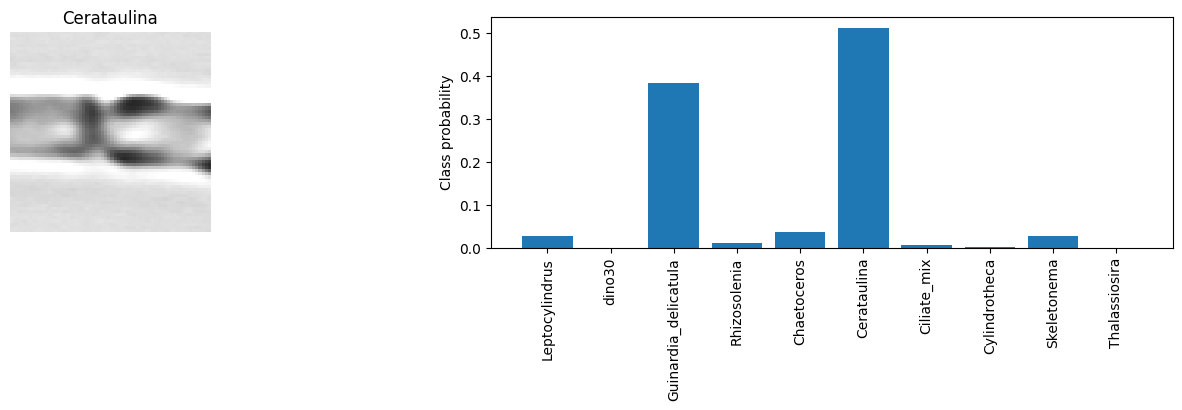

In [14]:
N=np.random.randint(0,X_val.shape[0]) # test some random image

x=np.expand_dims(X_val[N], axis=0)
predictions = CNN.predict(x)

class_name_true=keep_classes[Y_val[N,:]==1][0]

plt.figure(figsize=(15,3))
plt.subplot(1,5,1)
plt.imshow(x[0,:,:,0], cmap = 'gray', vmin = 0, vmax = 1)
plt.title(class_name_true)
plt.axis('off')

plt.subplot(1,5,(3,5))
plt.bar(keep_classes,predictions[0])
plt.xticks(rotation='vertical')
plt.ylabel('Class probability');
ax=plt.gca()
ax.grid(False)


## Metrics of accuracy: confusion matrix

We can look at which classes are being mistaken for one another by the network by plotting a 'confusion matrix'. The rows correspond to the true classes while the columns correspond to the predicted classes. So __confusion_matrix[i,j]__ = the number of examples with true class i, for which the class j was predicted. Entries along the diagonal correspond to correct predictions.

In [15]:
from sklearn.metrics import confusion_matrix

In [16]:
predictions = CNN.predict(X_val)
predictions_class=np.argmax(predictions, axis=1)

402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [17]:
conf_mat=confusion_matrix(class_labels_val, predictions_class)

conf_mat=conf_mat/ conf_mat.sum(axis=1, keepdims=True); # normalizing by the total number of samples
conf_mat=(conf_mat*100).round().astype(int)  # in per cent now, which is good for plotting!
# i.e. the % of the samples with true class i for which class j was predicted, so each row adds to 100%

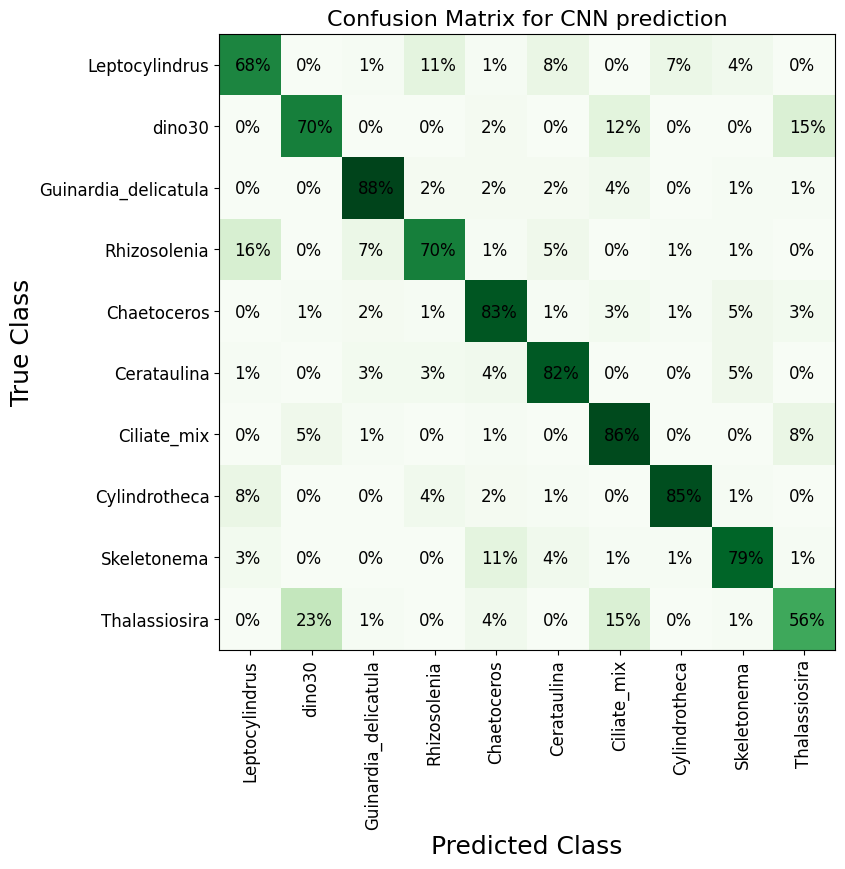

In [32]:
n=len(keep_classes)

plt.figure(figsize=(8,8))
plt.imshow(conf_mat, cmap='Greens',aspect=1)
ax=plt.gca()
plt.xticks(range(n), keep_classes, rotation='vertical',fontsize=12)
plt.yticks(range(n), keep_classes, fontsize=12)
plt.xlabel('Predicted Class', fontsize = 18)
plt.ylabel('True Class', fontsize = 18)
ax.grid(False)
plt.title('Confusion Matrix for CNN prediction',fontsize=16)
for i in range(n):
    for j in range(n):
        plt.text(i-0.25,j+0.1, str(conf_mat[j,i])+'%', fontsize=12);

As you can see, the network does much better for some classes than others!

## In-class exercise: Try adjusting the CNN complexity and seeing how this affects the performance and training

Try reducing the number of layers and number of filters in each convolutional layer to see what effect this has on the performance. We'll keep our original model saved as CNN, and create a new model (CNN_simple) then compare the performance of the two models.

In [ ]:
# Define a simpler CNN model
def create_simple_cnn_model(input_shape, output_shape):
    x = keras.layers.Input(shape=input_shape)

    y = keras.layers.Conv2D(4, (3,3), activation='relu', padding='same')(x) # Reduced filters
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(y) # Reduced filters
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(y) # Reduced filters
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.GlobalAveragePooling2D()(y)

    y = keras.layers.Dropout(0.5)(y)

    y = keras.layers.Dense(output_shape, activation='softmax')(y)

    model = keras.models.Model(inputs=x, outputs=y)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

CNN_simple = create_simple_cnn_model(input_shape=(64,64,1), output_shape=len(keep_classes))
CNN_simple.summary()

Now let's train the simpler model and compare its performance to the original.

In [ ]:
%%time
# Train the simpler model
n_epochs_simple = 20 # You can adjust the number of epochs
hist_simple = CNN_simple.fit(x = X_train, y = Y_train, epochs=n_epochs_simple, batch_size=512, validation_data=(X_val,Y_val))

Let's plot the training and validation accuracy for both models to compare.

In [ ]:
# Plot accuracy comparison
plt.figure(figsize=(12,8))
plt.plot(hist.history['val_accuracy'],label='Original CNN Validation')
plt.plot(hist.history['accuracy'],label='Original CNN Training')
plt.plot(hist_simple.history['val_accuracy'],label='Simple CNN Validation')
plt.plot(hist_simple.history['accuracy'],label='Simple CNN Training')
plt.ylim([0,1])
plt.hlines(0.1,0,max(n_epochs, n_epochs_simple)-1)
plt.annotate('Random Guess',(0, 0.12))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy');
plt.title('CNN Model Accuracy Comparison');